Connected to my_env (Python 3.9.18)

### Comparing ChIP-seq TF to genomic location with sliding window method predictions

This notebook uses ChIP-seq peaks from ChIP-Atlas as the input for calculating sliding window TF to peak binding scores. As the sliding window score attempts to match TFs to peaks, we can check the accuracy of our methods by comparing which TFs are predicted to bind the ChIP-seq peaks against the TFs that actually bound those locations.

The first thing that we need to do is to download and clean the ChIP-seq dataset to only contain the TF `gene_id`s and the formatted `peak_id`s.

The ChIP-Atlas dataset we are using can be downloaded from:

`wget https://chip-atlas.dbcls.jp/data/mm10/assembled/Oth.Emb.05.AllAg.AllCell.bed`

This file corresponds to the following settings in the Peak Browser:
- Species -> M. musculus (mm10)
- Track type class -> ChIP: TFs and others
- Cell type class -> Embryo
- Threshold for Significance -> 50
- Track type -> All
- Cell type -> all

In [3]:
!hostnamectl

   Static hostname: psh01com1hcom34
         Icon name: computer-server
           Chassis: server
        Machine ID: d82627f3a1704c039360f0e50457a01e
           Boot ID: 50b0727749f04af69390482cfafad02b
  Operating System: ]8;;https://www.redhat.com/Red Hat Enterprise Linux 8.10 (Ootpa)]8;;
       CPE OS Name: cpe:/o:redhat:enterprise_linux:8::baseos
            Kernel: Linux 4.18.0-553.22.1.el8_10.x86_64
      Architecture: x86-64


In [4]:
import os
import pandas as pd
import pybedtools
import seaborn as sns
import matplotlib.pyplot as plt
from grn_inference.utils import read_ground_truth, merge_dataset_with_ground_truth

base_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/"
ground_truth_dir = os.path.join(base_dir, "ground_truth_files")
output_dir = os.path.join(base_dir, "output/chipseq_sliding_window")
tmp_dir = os.path.join(output_dir, "tmp")

os.makedirs(ground_truth_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(tmp_dir, exist_ok=True)

In [5]:
def extract_gene_name(name):
    return name.split("Name=")[1].split("%")[0]

def format_peak_id(chrom, start, end):
    start = str(int(start))
    end = str(int(end))
    return "%s:%s-%s" % (chrom, start, end)

In [30]:
chip_bed_file = os.path.join(ground_truth_dir, "Oth.Emb.05.AllAg.AllCell.bed")
chip_bed = pybedtools.BedTool(chip_bed_file)
chip_bed_df = chip_bed.to_dataframe()
chip_bed_nohead = chip_bed_df.iloc[1:, :].dropna()

chip_bed_nohead["gene_id"] = chip_bed_nohead["name"].apply(extract_gene_name)
chip_bed_cleaned = chip_bed_nohead[["chrom", "start", "end", "gene_id"]]

# Set the peak_id as the formatted peak location
chip_bed_cleaned["peak_id"] = chip_bed_cleaned.apply(lambda x: format_peak_id(x.chrom, x.start, x.end), axis=1)

chip_tf_to_peak = chip_bed_cleaned[["gene_id", "peak_id"]]
chip_tf_to_peak

/tmp/ipykernel_462216/3085763299.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chip_bed_cleaned["peak_id"] = chip_bed_cleaned.apply(lambda x: format_peak_id(x.chrom, x.start, x.end), axis=1)


,gene_id,peak_id
1,Smad4,chr1:3003564-3003922
2,Ctcf,chr1:3012605-3012815
3,Ctcf,chr1:3012635-3012824
4,Epitope,chr1:3031387-3031654
5,Smad4,chr1:3031454-3031677
...,...,...
7624387,Rest,chrY_JH584303_random:135985-136047
7624388,Rest,chrY_JH584303_random:135985-136048
7624389,Rest,chrY_JH584303_random:135986-136045
7624390,Rest,chrY_JH584303_random:135989-136043


Now that we have the ChIP-Atlas peaks in the format that we want, we can save it to the ground truth directory for later

In [5]:
chip_tf_to_peak.to_csv(os.path.join(ground_truth_dir, "chipatlas_mESC.csv"), header=True, index=False)

### Creating the Homer peaks file

Next, we need to format the peaks to follow the same requirements as the Homer peaks file. The sliding window method also uses this format for convenience.

> HOMER peak files should have at minimum 5 columns (separated by TABs, additional columns will be ignored:
> - Column1: Unique Peak ID
> - Column2: chromosome
> - Column3: starting position
> - Column4: ending position
> - Column5: Strand (+/- or 0/1, where 0="+", 1="-")

In [6]:
# NOTE: I am overriding the workflow to load in the dataset of overlapping ChIP-Atlas and BEELINE edges
# See "map_chip_atlas_to_beeline_ground_truth.ipynb" for how this was created.
chip_bed_cleaned = pd.read_csv(os.path.join(ground_truth_dir, "chipatlas_beeline_mESC_shared_edges.csv"), header=0, index_col=False)
chip_bed_cleaned["peak_id"] = chip_bed_cleaned.apply(lambda x: format_peak_id(x.chrom, x.start, x.end), axis=1)
chip_tf_to_peak = chip_bed_cleaned[["source_id", "peak_id"]].rename(columns={"source_id":"gene_id"})
chip_tf_to_peak

,gene_id,peak_id
0,ASCL1,chr5:114173037-114173222
1,ASCL1,chr5:114173103-114173157
2,ASCL1,chr11:114795327-114795552
3,ASCL1,chr11:114795386-114795436
4,ASCL1,chr7:28302269-28302413
...,...,...
1721457,ZFP281,chr4:119422622-119422859
1721458,ZFP281,chr2:165900305-165900542
1721459,ZFP281,chr2:165906423-165906828
1721460,ZFP281,chr2:165922264-165922501


In [31]:
# Format the DataFrame to follow the requirements for the Homer peaks file (used for both Homer and sliding window)
homer_peaks = chip_bed_cleaned[["peak_id", "chrom", "start", "end"]]
homer_peaks["start"] = round(homer_peaks["start"].astype(int),0)
homer_peaks["end"] = round(homer_peaks["end"].astype(int),0)
homer_peaks = homer_peaks[["chrom", "start", "end", "peak_id"]]
homer_peaks

/tmp/ipykernel_462216/2201842266.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  homer_peaks["start"] = round(homer_peaks["start"].astype(int),0)
/tmp/ipykernel_462216/2201842266.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  homer_peaks["end"] = round(homer_peaks["end"].astype(int),0)


,chrom,start,end,peak_id
1,chr1,3003564,3003922,chr1:3003564-3003922
2,chr1,3012605,3012815,chr1:3012605-3012815
3,chr1,3012635,3012824,chr1:3012635-3012824
4,chr1,3031387,3031654,chr1:3031387-3031654
5,chr1,3031454,3031677,chr1:3031454-3031677
...,...,...,...,...
7624387,chrY_JH584303_random,135985,136047,chrY_JH584303_random:135985-136047
7624388,chrY_JH584303_random,135985,136048,chrY_JH584303_random:135985-136048
7624389,chrY_JH584303_random,135986,136045,chrY_JH584303_random:135986-136045
7624390,chrY_JH584303_random,135989,136043,chrY_JH584303_random:135989-136043


In [11]:
from grn_inference.utils import read_ground_truth
rn111_chipseq_ground_truth = read_ground_truth("/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SC_MO_TRN_DB.MIRA/REPOSITORY/CURRENT/REFERENCE_NETWORKS/RN111_ChIPSeq_BEELINE_Mouse_ESC.tsv").drop(columns=["Relationship"])
rn111_chipseq_ground_truth['source_id'] = rn111_chipseq_ground_truth['source_id'].str.upper()
rn111_chipseq_ground_truth['target_id'] = rn111_chipseq_ground_truth['target_id'].str.upper()
rn111_chipseq_ground_truth

,source_id,target_id
0,ADNP,MIS18BP1
1,ADNP,EXD1
2,ADNP,CHP1
3,ADNP,OSCAR
4,ADNP,NDUFA3
...,...,...
977836,ZIC3,ZFP36L3
977837,ZIC3,ZFP499
977838,ZIC3,ZFP57
977839,ZIC3,ZFP91


This is a huge file - we dont need to test the method using all of them. We will take a sample to run the scoring on.

In [24]:
homer_peaks_sample = homer_peaks.sample(frac=0.05)

If we save the ChIP-seq peaks as `homer_peaks.txt` to the `tmp` directory of the output folder, then they will be used to calculate the sliding window and Homer scores

In [4]:
homer_peak_path = os.path.join(tmp_dir, "homer_peaks.txt")

In [16]:
homer_peaks.to_csv(homer_peak_path, sep="\t", header=True, index=False)

Reload `homer_peaks` if needed

In [13]:
homer_peaks = pd.read_csv(homer_peak_path, sep="\t", header=0, index_col=None)

In [32]:
homer_peaks

,chrom,start,end,peak_id
1,chr1,3003564,3003922,chr1:3003564-3003922
2,chr1,3012605,3012815,chr1:3012605-3012815
3,chr1,3012635,3012824,chr1:3012635-3012824
4,chr1,3031387,3031654,chr1:3031387-3031654
5,chr1,3031454,3031677,chr1:3031454-3031677
...,...,...,...,...
7624387,chrY_JH584303_random,135985,136047,chrY_JH584303_random:135985-136047
7624388,chrY_JH584303_random,135985,136048,chrY_JH584303_random:135985-136048
7624389,chrY_JH584303_random,135986,136045,chrY_JH584303_random:135986-136045
7624390,chrY_JH584303_random,135989,136043,chrY_JH584303_random:135989-136043


In [35]:
from pybiomart import Server
import numpy as np
from typing import Union
import grn_inference.utils as utils

import importlib
importlib.reload(utils)

def load_ensembl_organism_tss(organism, tmp_dir):
    if not os.path.exists(os.path.join(tmp_dir, "ensembl.parquet")):
        print(f"Loading Ensembl TSS locations for {organism}")
        # Connect to the Ensembl BioMart server
        server = Server(host='http://www.ensembl.org')

        gene_ensembl_name = f'{organism}_gene_ensembl'
        
        # Select the Ensembl Mart dataset
        mart = server['ENSEMBL_MART_ENSEMBL']
        try:
            dataset = mart[gene_ensembl_name]
        except KeyError:
            raise RuntimeError(f"BioMart dataset {gene_ensembl_name} not found. Check if ‘{organism}’ is correct.")

        # Query for attributes: Ensembl gene ID, gene name, strand, and transcription start site (TSS)
        ensembl_df = dataset.query(attributes=[
            'external_gene_name', 
            'strand', 
            'chromosome_name',
            'transcription_start_site'
        ])

        ensembl_df.rename(columns={
            "Chromosome/scaffold name": "chr",
            "Transcription start site (TSS)": "tss",
            "Gene name": "gene_id"
        }, inplace=True)
        
        # Make sure TSS is integer (some might be floats).
        ensembl_df["tss"] = ensembl_df["tss"].astype(int)

        # In a BED file, we’ll store TSS as [start, end) = [tss, tss+1)
        ensembl_df["start"] = ensembl_df["tss"].astype(int)
        ensembl_df["end"] = ensembl_df["tss"].astype(int) + 1

        # Re-order columns for clarity: [chr, start, end, gene]
        ensembl_df = ensembl_df[["chr", "start", "end", "gene_id"]]
        
        ensembl_df["chr"] = ensembl_df["chr"].astype(str)
        ensembl_df["gene_id"] = ensembl_df["gene_id"].astype(str)
        
        # Write the peak DataFrame to a file
        ensembl_df.to_parquet(os.path.join(tmp_dir, "ensembl.parquet"), engine="pyarrow", index=False, compression="snappy")
        
    else:
        print("Ensembl gene TSS BED file exists, loading...")
        print(f"  Loading {os.path.join(tmp_dir, 'ensembl.parquet')}")
        ensembl_df = pd.read_parquet(os.path.join(tmp_dir, "ensembl.parquet"), engine="pyarrow")
    
    return ensembl_df

def calculate_tss_distance_score(
    peak_bed: pybedtools.BedTool, 
    tss_bed: pybedtools.BedTool, 
    gene_names: set[str], 
    tss_distance_cutoff: Union[int, float] = 1e6
    ):
    """
    Identify genes whose transcription start sites (TSS) are near scATAC-seq peaks.
    
    This function:
        1. Calculates the absolute distances between peaks and gene TSSs within `tss_distance_cutoff`.
        2. Scales peak to gene distances using an exponential drop-off function (e^-dist/250000),
           the same method used in the LINGER cis-regulatory potential calculation.
        3. Deduplicates the data to keep the minimum (i.e., best) peak-to-gene connection.
        4. Only keeps genes that are present in the RNA-seq dataset.
        
    Args:
        peak_bed (pybedtools.BedTool):
            BedTool object representing scATAC-seq peaks.
        tss_bed (pybedtools.BedTool):
            BedTool object representing gene TSS locations.
        gene_names (set[str]):
            Set of gene names from the scRNA-seq dataset.
        tss_distance_cutoff (int): 
            The maximum distance (in bp) from a TSS to consider a peak as potentially regulatory.
        
    Returns:
        peak_tss_subset_df (pandas.DataFrame): 
            A DataFrame containing columns "peak_id", "target_id", and the scaled TSS distance "TSS_dist"
            for peak–gene pairs.
    """
                
    
    # sort on the fly to enable bedtools streaming
    peak_bed = peak_bed.sort(stream=True)
    tss_bed  = tss_bed.sort(stream=True)

    # nearest TSS only, with distance column appended
    # (bedtools closest -d -t first)
    res = peak_bed.closest(tss_bed, d=True, t="first")

    df = res.to_dataframe(
        names=[
            "peak_chr","peak_start","peak_end","peak_id",
            "gene_chr","gene_start","gene_end","target_id",
            "TSS_dist"
        ],
        # let pandas infer dtypes to avoid costly coercions
        low_memory=True,
    )

    # keep only genes present in your RNA data (case-insensitive)
    if gene_names:
        gset = {g.upper() for g in gene_names}
        df = df[df["target_id"].str.upper().isin(gset)]

    # enforce cutoff (closest may be farther than cutoff)
    df = df[df["TSS_dist"] <= tss_distance_cutoff]

    # score = exp(-dist/250000) like LINGER
    df["TSS_dist_score"] = np.exp(-df["TSS_dist"] / 250_000.0)

    # keep minimal columns (already nearest, so no dedupe needed)
    out = df.loc[:, ["peak_id", "target_id", "TSS_dist_score"]].copy()

    print(f"\t- Peaks with a nearby TSS: {out['peak_id'].nunique():,}")
    return out

organism = "mmusculus"

if not os.path.exists(os.path.join(output_dir, "tss_distance_score.parquet")):
        
        tss_df: pd.DataFrame = load_ensembl_organism_tss(organism, tmp_dir)
        
        if "chr" in tss_df.columns:
            tss_df = tss_df.rename(columns={"chr": "chrom"})
        
        # Make sure that each chromosome starts with "chr"
        tss_df["chrom"] = np.where(
            tss_df["chrom"].astype(str).str.startswith("chr"),
            tss_df["chrom"],
            "chr" + tss_df["chrom"].astype(str)
        )
        
        tss_df = tss_df.rename(columns={"chr": "chrom"})
        print(tss_df.head())
        print(homer_peaks.head())
        print(homer_peaks.shape)
                
        homer_peaks = homer_peaks[["chrom", "start", "end", "peak_id"]]
        tss_df = tss_df[["chrom", "start", "end", "gene_id"]]

        pybedtools.set_tempdir(tmp_dir)
        try:
            peak_bed = pybedtools.BedTool.from_dataframe(homer_peaks)
            tss_bed = pybedtools.BedTool.from_dataframe(tss_df)
            
            assert os.path.isdir(output_dir), "`output_dir` is not a directory"
            
            gene_names = set([gene for gene in chip_tf_to_peak["gene_id"]])


            peak_tss_subset_df = calculate_tss_distance_score(
                peak_bed,
                tss_bed,
                gene_names,
                1_000_000
            )
            
            # peak_tss_subset_df = minmax_normalize_pandas(
            #     df=peak_tss_subset_df, 
            #     score_cols=["TSS_dist_score"], 
            #     )
                
            peak_tss_subset_df.to_parquet(os.path.join(output_dir, "tss_distance_score.parquet"), index=False, engine="pyarrow", compression="snappy")
        finally:
            pybedtools.helpers.cleanup(verbose=False, remove_all=True) 
else:
    print('TSS distance file exists, loading...')
    peak_tss_subset_df = pd.read_parquet(os.path.join(output_dir, "tss_distance_score.parquet"), engine="pyarrow")

Ensembl gene TSS BED file exists, loading...
  Loading /gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/chipseq_sliding_window/tmp/ensembl.parquet
   chrom  start   end  gene_id
0  chrMT      1     2    mt-Tf
1  chrMT     70    71  mt-Rnr1
2  chrMT   1025  1026    mt-Tv
3  chrMT   1094  1095  mt-Rnr2
4  chrMT   2676  2677   mt-Tl1
  chrom    start      end               peak_id
1  chr1  3003564  3003922  chr1:3003564-3003922
2  chr1  3012605  3012815  chr1:3012605-3012815
3  chr1  3012635  3012824  chr1:3012635-3012824
4  chr1  3031387  3031654  chr1:3031387-3031654
5  chr1  3031454  3031677  chr1:3031454-3031677
(7624391, 4)
	- Peaks with a nearby TSS: 23,201


Next, we run `run_sliding_window_on_chipseq_peaks.sh` in the `dev/testing_scripts` directory

In [38]:
!sbatch /gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/testing_scripts/run_sliding_window_on_chipseq_peaks.sh

Submitted batch job 3384960


Once the sliding window calculation is done, we can read in the output.

In [39]:

sliding_window_df = pd.read_parquet(os.path.join(output_dir, "no_norm_sliding_window_tf_to_peak_score.parquet"), engine="pyarrow")
sliding_window_df = sliding_window_df.reset_index(drop=True)
sliding_window_df

,peak_id,source_id,sliding_window_score
0,chr17:46704666-46705502,Ascl1,18836.157784
1,chr17:3456010-3456318,Ascl1,6543.452178
2,chr17:56255512-56256229,Ascl1,15508.133754
3,chr17:69382560-69382744,Ascl1,4256.191542
4,chr17:86555341-86555555,Ascl1,4312.891574
...,...,...,...
7488346,chr11:51936197-51936397,Zfp335,7371.634079
7488347,chr11:100846598-100846664,Zfp335,2121.398070
7488348,chr11:108891288-108891643,Zfp335,13014.262983
7488349,chr11:87771063-87771282,Zfp335,8039.550073


We can use the `chip_tf_to_peak` object that we created from the ChIP-Atlas file to check our work. Since we sampled the ChIP-Atlas peaks before running the sliding window calculations, we need to subset `chip_tf_to_peak` to only contain those peaks.

In [40]:
sliding_window_df["source_id"] = sliding_window_df["source_id"].str.upper()
chip_tf_to_peak["gene_id"] = chip_tf_to_peak["gene_id"].str.upper()

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/chipseq_sliding_window/tmp/ipykernel_462216/3625471141.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chip_tf_to_peak["gene_id"] = chip_tf_to_peak["gene_id"].str.upper()


In [41]:
chip_tf_to_peak_sub = chip_tf_to_peak[
    (chip_tf_to_peak["peak_id"].isin(sliding_window_df["peak_id"])) &
    (chip_tf_to_peak["gene_id"].isin(sliding_window_df["source_id"]))
    ]
chip_tf_to_peak_sub

,gene_id,peak_id
401,REST,chr1:3670770-3670855
484,CTCF,chr1:3672215-3672538
1831,TCF3,chr1:4779120-4779177
2510,CTCF,chr1:5017906-5018204
2650,CTCF,chr1:5070240-5070596
...,...,...
7607456,CTCF,chrY:11857983-11858300
7611309,CTCF,chrY:35978139-35978355
7611316,CTCF,chrY:35978154-35978351
7611492,CTCF,chrY:37551909-37552175


We then combine the TF-peak mapping from ChIP-Atlas with the TF-peak mapping from the sliding window score by merging the two DataFrames on `peak_id`.

In [42]:

merged_df = pd.merge(chip_tf_to_peak_sub, sliding_window_df, on="peak_id", how="inner")
merged_df = merged_df.rename(columns={"gene_id": "chip_gene", "source_id": "sliding_window_gene"})
merged_df = merged_df[["chip_gene", "sliding_window_gene", "peak_id", "sliding_window_score"]]
merged_df

,chip_gene,sliding_window_gene,peak_id,sliding_window_score
0,REST,ASCL1,chr1:3670770-3670855,1776.750220
1,REST,CDX2,chr1:3670770-3670855,1051.804907
2,REST,CEBPA,chr1:3670770-3670855,1003.005789
3,REST,CREB1,chr1:3670770-3670855,1227.633637
4,REST,CTCF,chr1:3670770-3670855,1944.025267
...,...,...,...,...
6140890,CTCF,TWIST1,chrY:63471202-63471366,4365.138945
6140891,CTCF,WT1,chrY:63471202-63471366,4966.008166
6140892,CTCF,ZEB1,chrY:63471202-63471366,2478.835532
6140893,CTCF,ZFP281,chrY:63471202-63471366,2482.208951


In [43]:
merged_df.to_csv(os.path.join(output_dir, "chipseq_sliding_window_merged.csv"), header=True, index=False)

We can extract the correct predictions and the incorrect predictions, and see how the sliding window scores vary between them.

In [44]:
import dask.dataframe as dd


merged_ddf = dd.from_pandas(merged_df, npartitions=100)
merged_df_sample = merged_ddf.sample(frac=0.05, random_state=42).compute()


correct_predictions = merged_df_sample[merged_df_sample["chip_gene"].str.upper() == merged_df_sample["sliding_window_gene"].str.upper()]
incorrect_predictions = merged_df_sample[merged_df_sample["chip_gene"].str.upper() != merged_df_sample["sliding_window_gene"].str.upper()]

print(f"Num correct predictions: {len(correct_predictions)}")
print(f"Num incorrect predictions: {len(incorrect_predictions)}")

print(f"Num unique correct TFs: {len(correct_predictions.drop_duplicates(subset=['chip_gene', 'sliding_window_gene']))}")
print(f"Num unique inorrect TFs: {len(incorrect_predictions.drop_duplicates(subset=['chip_gene', 'sliding_window_gene']))}")

Num correct predictions: 3436
Num incorrect predictions: 303564
Num unique correct TFs: 13
Num unique inorrect TFs: 1252


Since each TF and peak has a potential binding score, there will be a lot more incorrect predictions than correct predictions. We will sample each DataFrame by the one with the minimum number of rows so they are equal in length.

In [45]:
correct_prediction_scores = correct_predictions["sliding_window_score"].sample(
    min(len(correct_predictions), len(incorrect_predictions))
    ).rename("Correct TF Binding Predictions").reset_index(drop=True)

incorrect_prediction_scores = incorrect_predictions["sliding_window_score"].sample(
    min(len(correct_predictions), len(incorrect_predictions))
    ).rename("Incorrect TF Binding Predictions").reset_index(drop=True)

print(f"Num correct predictions: {len(correct_prediction_scores)}")
print(f"Num incorrect predictions: {len(incorrect_prediction_scores)}")

Num correct predictions: 3436
Num incorrect predictions: 3436


Now that we have extracted the correct and incorrect scores, we will merge them to create a new dataframe containing just the correct and incorrect scores.

In [46]:
pred_df = pd.merge(correct_prediction_scores, incorrect_prediction_scores, left_index=True, right_index=True)

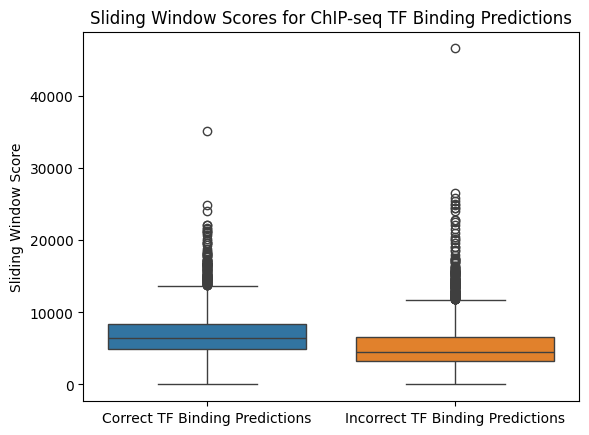

In [47]:
fig = plt.Figure()
a = sns.boxplot(data=pred_df)
a.set_ylabel("Sliding Window Score")
a.set_title("Sliding Window Scores for ChIP-seq TF Binding Predictions")
plt.savefig("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/chipseq_sliding_window/chipseq_sliding_window_boxplot.png", dpi=200)

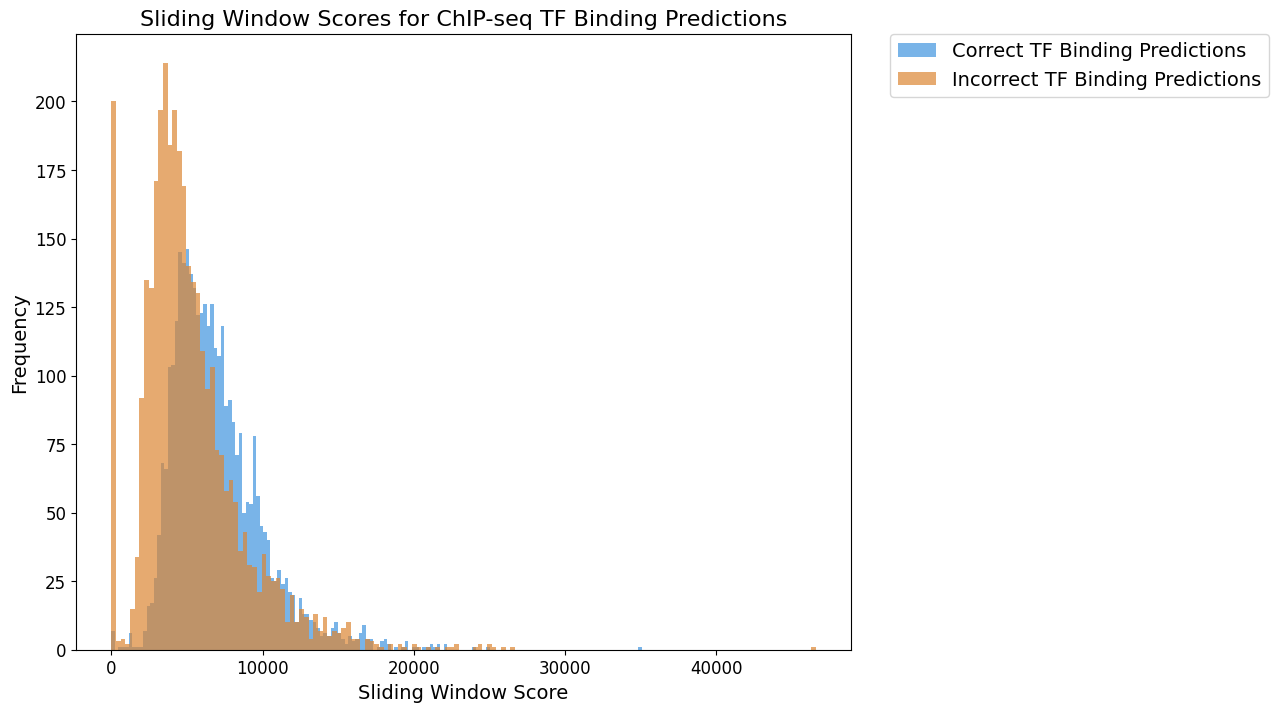

In [48]:
plt.figure(figsize=(10,8))
plt.hist(
    pred_df["Correct TF Binding Predictions"],
    bins=150,
    alpha=0.7,
    color='#4195df',
    label="Correct TF Binding Predictions"
)
plt.hist(
    pred_df["Incorrect TF Binding Predictions"],
    bins=150,
    alpha=0.7,
    color='#dc8634',
    label="Incorrect TF Binding Predictions"
)
plt.title("Sliding Window Scores for ChIP-seq TF Binding Predictions", fontsize=16)
plt.xlabel("Sliding Window Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)
plt.savefig("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/chipseq_sliding_window/chipseq_sliding_window_histogram.png", dpi=200)